The data was taken from https://www.kaggle.com/datasets/bhavikjikadara/loan-status-prediction <br>
The goal is to build a machine learning model to predict whether a loan will be approved or rejected for an applicant. <br>
About the loan_data.csv file:

    Loan_ID: A unique loan ID.
    Gender: Either male or female.
    Married: Weather Married(yes) or Not Marttied(No).
    Dependents: Number of persons depending on the client.
    Education: Applicant Education(Graduate or Undergraduate).
    Self_Employed: Self-employed (Yes/No).
    ApplicantIncome: Applicant income.
    CoapplicantIncome: Co-applicant income.
    LoanAmount: Loan amount in thousands.
    Loan_Amount_Term: Terms of the loan in months.
    Credit_History: Credit history meets guidelines.
    Property_Area: Applicants are living either Urban, Semi-Urban or Rural.
    Loan_Status: Loan approved (Y/N).

## Imports

In [37]:
import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from tqdm.notebook import trange, tqdm
RANDOM_STATE = 10

## Data

In [38]:
df = pd.read_csv("loan_data.csv")
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,LP002953,Male,Yes,3+,Graduate,No,5703,0.0,128.0,360.0,1.0,Urban,Y
377,LP002974,Male,Yes,0,Graduate,No,3232,1950.0,108.0,360.0,1.0,Rural,Y
378,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
379,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y


Deleting the "Loan_ID" column because it is an identifier

In [39]:
del df["Loan_ID"]

Columns with missing values

In [40]:
columns_with_missing_values = df.columns[df.isnull().any()].tolist() # get columns with missing values
print(columns_with_missing_values)

['Gender', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']


Number of rows with missing values

In [41]:
num_rows_with_missing_values = df.isnull().any(axis=1).sum() # get number of rows with missing values
print(num_rows_with_missing_values)

73


'Credit_History' is a nominal column, but it contains real values, so first we convert 'Credit_History' to text

In [42]:
df['Credit_History'] = df['Credit_History'].replace({1: 'Yes', 0: 'No'})

**Displaying nominal and ordinal features**

In [43]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns # select categorical columns
for column in categorical_columns:
    unique_values = df[column].unique()
    print(f"Column: {column}")
    print(f"Unique Values: {unique_values}")
    print()


Column: Gender
Unique Values: ['Male' 'Female' nan]

Column: Married
Unique Values: ['Yes' 'No']

Column: Dependents
Unique Values: ['1' '0' '2' '3+' nan]

Column: Education
Unique Values: ['Graduate' 'Not Graduate']

Column: Self_Employed
Unique Values: ['No' 'Yes' nan]

Column: Credit_History
Unique Values: ['Yes' nan 'No']

Column: Property_Area
Unique Values: ['Rural' 'Urban' 'Semiurban']

Column: Loan_Status
Unique Values: ['N' 'Y']



**Class Label Encoding**

In [44]:
class_le = LabelEncoder()
df['Loan_Status'] = class_le.fit_transform(df['Loan_Status'].values)
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,Yes,Rural,0
1,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,Yes,Urban,1
2,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,Yes,Urban,1
3,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,Yes,Urban,1
4,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,Yes,Urban,1
...,...,...,...,...,...,...,...,...,...,...,...,...
376,Male,Yes,3+,Graduate,No,5703,0.0,128.0,360.0,Yes,Urban,1
377,Male,Yes,0,Graduate,No,3232,1950.0,108.0,360.0,Yes,Rural,1
378,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,Yes,Rural,1
379,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,Yes,Rural,1


In [45]:
mapping = dict(zip(range(len(class_le.classes_)), class_le.classes_)) # mapping of class labels to class names used by class_le
print(mapping)

{0: 'N', 1: 'Y'}


# **Categorical data processing**

**Unitary coding of nominal features**

In [46]:
ct = ColumnTransformer([('onehot', OneHotEncoder(categories='auto', drop='first'), [0,1,4,9,10]),
                        ('onehot_pass', OneHotEncoder(categories='auto'), [3]),
                        ('nothing', 'passthrough', [5,6,7,8])])
ct.fit(df)
column_names = ct.get_feature_names_out()
transformed_values = ct.transform(df).astype(float)

idx = np.where(column_names == "onehot_pass__Education_Not Graduate")[0][0] # delete extra column to prevent collinearity
transformed_values = np.delete(transformed_values, idx, axis=1)
column_names = np.delete(column_names, idx)

new_df = pd.DataFrame(transformed_values, columns=column_names)
new_df

,onehot__Gender_Male,onehot__Gender_nan,onehot__Married_Yes,onehot__Self_Employed_Yes,onehot__Self_Employed_nan,onehot__Credit_History_Yes,onehot__Credit_History_nan,onehot__Property_Area_Semiurban,onehot__Property_Area_Urban,onehot_pass__Education_Graduate,nothing__ApplicantIncome,nothing__CoapplicantIncome,nothing__LoanAmount,nothing__Loan_Amount_Term
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4583.0,1508.0,128.0,360.0
1,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,3000.0,0.0,66.0,360.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2583.0,2358.0,120.0,360.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,6000.0,0.0,141.0,360.0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2333.0,1516.0,95.0,360.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5703.0,0.0,128.0,360.0
377,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3232.0,1950.0,108.0,360.0
378,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2900.0,0.0,71.0,360.0
379,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4106.0,0.0,40.0,180.0


**Ordinal features encoding**

In [47]:
new_df['dep. > 0'] = df['Dependents'].apply(lambda x: 1 if x in {'1', '2', '3+'} else 0)
new_df['dep. > 1'] = df['Dependents'].apply(lambda x: 1 if x == {'2', '3+'} else 0)
new_df['dep. > 2'] = df['Dependents'].apply(lambda x: 1 if x == '3+' else 0)
new_df['unknown dep.'] = df['Dependents'].apply(lambda x: 1 if isinstance(x, float) and np.isnan(x) else 0)
new_df['Loan_Status'] = df['Loan_Status'].copy()

new_df

,onehot__Gender_Male,onehot__Gender_nan,onehot__Married_Yes,onehot__Self_Employed_Yes,onehot__Self_Employed_nan,onehot__Credit_History_Yes,onehot__Credit_History_nan,onehot__Property_Area_Semiurban,onehot__Property_Area_Urban,onehot_pass__Education_Graduate,nothing__ApplicantIncome,nothing__CoapplicantIncome,nothing__LoanAmount,nothing__Loan_Amount_Term,dep. > 0,dep. > 1,dep. > 2,unknown dep.,Loan_Status
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4583.0,1508.0,128.0,360.0,1,0,0,0,0
1,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,3000.0,0.0,66.0,360.0,0,0,0,0,1
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2583.0,2358.0,120.0,360.0,0,0,0,0,1
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,6000.0,0.0,141.0,360.0,0,0,0,0,1
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2333.0,1516.0,95.0,360.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5703.0,0.0,128.0,360.0,1,0,1,0,1
377,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3232.0,1950.0,108.0,360.0,0,0,0,0,1
378,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2900.0,0.0,71.0,360.0,0,0,0,0,1
379,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4106.0,0.0,40.0,180.0,1,0,1,0,1


### We received a dataset with encoded nominal and ordinal features, as well as class labels

# **Resolving the problem of missing data**
The dataset sklearn.datasets.fetch_california_housing from https://github.com/scikit-learn/scikit-learn/blob/9e38cd00d/sklearn/datasets/_california_housing.py#L54 was selected, which considers the problem of predicting the average price of housing (regression)

**Identifying missing values ​​in tabular data**

In [61]:
from sklearn.datasets import fetch_california_housing

np.random.seed(RANDOM_STATE)
data = fetch_california_housing(as_frame=True)
# We will use approximately 2000 records to make this run faster (each 10th record)
df = data['frame'][::10]
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
10,3.2031,52.0,5.477612,1.079602,910.0,2.263682,37.85,-122.26,2.815
20,1.3578,40.0,4.524096,1.108434,409.0,2.463855,37.85,-122.27,1.475
30,1.9274,49.0,5.068783,1.182540,863.0,2.283069,37.84,-122.28,1.223
40,2.0978,52.0,4.215190,1.060759,946.0,2.394937,37.83,-122.26,1.554
...,...,...,...,...,...,...,...,...,...
20590,1.6840,41.0,4.226629,0.991501,804.0,2.277620,39.14,-121.59,0.713
20600,3.1029,18.0,4.945455,1.112121,769.0,2.330303,39.16,-121.57,0.717
20610,1.3631,28.0,4.851936,1.102506,1195.0,2.722096,39.10,-121.56,0.455
20620,4.5625,40.0,4.125000,0.854167,151.0,3.145833,39.05,-121.48,1.000


Removing a random value from each row

In [62]:
# Get the number of rows and columns in the dataframe
num_rows, num_cols = df.shape
df_removed = df.copy()

# Iterate over each row
for i in range(num_rows):
    # Choose a random column index except the last one
    random_col_index = np.random.randint(num_cols-1)
    
    # Set the value in the random column for the current row to np.nan
    df_removed.iloc[i, random_col_index] = np.nan

df_removed

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,NaN,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
10,3.2031,52.0,5.477612,1.079602,910.0,NaN,37.85,-122.26,2.815
20,1.3578,40.0,4.524096,1.108434,NaN,2.463855,37.85,-122.27,1.475
30,1.9274,49.0,5.068783,1.182540,863.0,2.283069,37.84,NaN,1.223
40,NaN,52.0,4.215190,1.060759,946.0,2.394937,37.83,-122.26,1.554
...,...,...,...,...,...,...,...,...,...
20590,1.6840,41.0,4.226629,0.991501,NaN,2.277620,39.14,-121.59,0.713
20600,3.1029,18.0,4.945455,NaN,769.0,2.330303,39.16,-121.57,0.717
20610,1.3631,NaN,4.851936,1.102506,1195.0,2.722096,39.10,-121.56,0.455
20620,4.5625,40.0,4.125000,NaN,151.0,3.145833,39.05,-121.48,1.000


<Axes: >

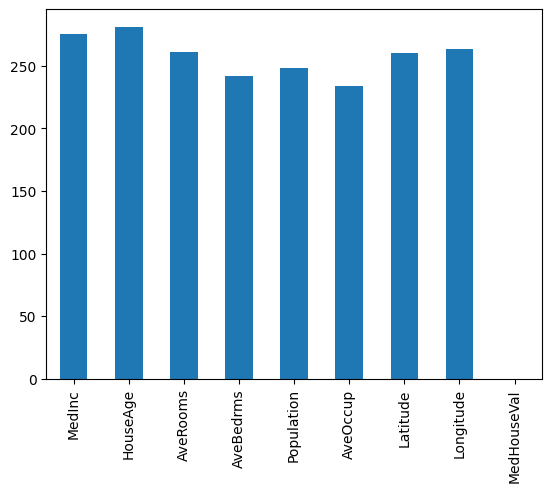

In [63]:
df_removed.isnull().sum().plot(kind='bar') # plot the number of missing values in each column

As we can see, the number of missing values ​​in each column is approximately the same (there are no missing values ​​in the target variable)

# **Filling missing values ​​by interpolation**

In [64]:
NUM_SPLITS = 5 # number of cross-validation splits

df_arr = df.values # convert dataframe to numpy array
df_arr_removed = df_removed.values 

X_full = df_arr[:,:8] # get the feature columns
y_full = df_arr[:,8] # get the target column

X_removed = df_arr_removed[:,:8]
y_removed = df_arr_removed[:,8]
n_samples, n_features = X_full.shape

RF_regressor = RandomForestRegressor(random_state=RANDOM_STATE) # create a random forest regressor used for target prediction

In [65]:
X_full.shape

(2064, 8)

Let's find the MSE for the selected regressor on the original data

In [66]:
full_data_score = pd.DataFrame( 
    cross_val_score(
        RF_regressor, X_full, y_full, scoring="neg_mean_squared_error", cv=NUM_SPLITS
    ),
    columns=["Prediction on Full Data"],
) # get the cross-validation score for the full data

In [67]:
def get_scores_for_imputer(imputer, X_removed=X_removed, y_removed=y_removed,
                           regressor=RF_regressor, num_splits=NUM_SPLITS):
    estimator = make_pipeline(imputer, regressor)
    impute_scores = cross_val_score(
        estimator, X_removed, y_removed, scoring="neg_mean_squared_error", cv=num_splits
    )
    return impute_scores # function to get the cross-validation score for the imputer

As data filling algorithms, we will consider:

    KNNImputer
    SimpleImputer
    IterativeImputer

As strategies for algorithms (except KNNImputer) we will consider:

    mean - filling the column with the mean value
    median - filling the column with the median
    most_frequent - filling the column with the mode
    constant - filling with a constant, in this case with zeros

As regression models for estimating missing values ​​when using, we will consider:

    BayesianRidge - regularized linear regression
    KNeighborsRegressor - regression model based on k nearest neighbors
    DecisionTreeRegressor - regression model based on decision trees
    ExtraTreesRegressor - meta-model that builds a set of random trees (so-called extra-trees) on different subsamples of the data set
    RandomForestRegressor - regression model based on a forest of random trees
    Nystroem(kernel="polynomial", degree=2) and Ridge pipeline - pipeline with expansion of the 2nd degree polynomial kernel and regularized linear regression

In [68]:
imputer_scores = pd.DataFrame()
strategies = ("mean", "median", "most_frequent", "constant") # list of strategies for SimpleImputer and IterativeImputer
estimators = [
    BayesianRidge(),
    KNeighborsRegressor(n_neighbors=15),
    DecisionTreeRegressor(
        max_depth=5, min_samples_split=5, min_samples_leaf=3
    ),
    ExtraTreesRegressor(
        max_depth=10, min_samples_split=3
    ),
    RandomForestRegressor(
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=0,
    ),
    make_pipeline(
        Nystroem(kernel="polynomial", degree=2, random_state=RANDOM_STATE),
        Ridge(alpha=1e3)
    ),
] # list of estimators for IterativeImputer
combinations = list(it.product(estimators, strategies))
tol_arr = (1e-3, *[1e-1]*4, 1e-2) # list of tolerance values for IterativeImputer

imputers = [
    KNNImputer(add_indicator=True),
    *[SimpleImputer(strategy=strat, add_indicator=True) for 
        strat in strategies],
    *[IterativeImputer(random_state=RANDOM_STATE,
                       estimator=est,
                       max_iter=25,
                       tol=tol_arr[idx // len(strategies)],
                       initial_strategy=init_strat,
                       add_indicator=True) for 
        idx, (est, init_strat) in enumerate(combinations)],
]

method_names = ["KNNImputer",
                *["SimpleImputer " + strat for strat in strategies],
                *["IterativeImputer " + init_strat + " " + est.__class__.__name__ for est, init_strat in combinations]]

for idx, imputer in tqdm(enumerate(imputers), total=len(imputers)):
    imputer_scores[method_names[idx]] = get_scores_for_imputer(imputer)

scores = pd.concat([full_data_score, imputer_scores], axis=1)

  0%|          | 0/29 [00:00<?, ?it/s]

c:\Users\Oleksiy\anaconda3\envs\BigDataEnv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\Oleksiy\anaconda3\envs\BigDataEnv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\Oleksiy\anaconda3\envs\BigDataEnv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\Oleksiy\anaconda3\envs\BigDataEnv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


**Diagram of the results**

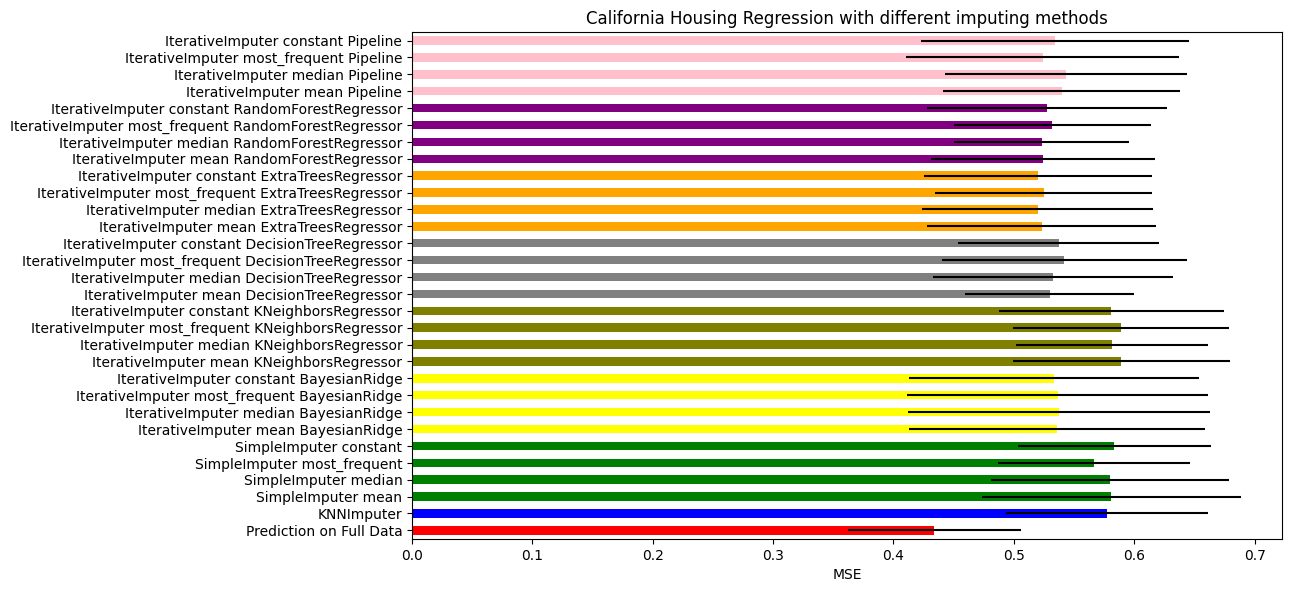

In [81]:
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean() # due to neg_mean_squared_error
errors = scores.std()
colors = ['red', 'blue'] +\
    list(it.chain.from_iterable(
        [color]*4 for color in ['green', 'yellow', 'olive', 'grey', 'orange', 'purple', 'pink'])) # array of colors

means.plot.barh(xerr=errors, ax=ax, color=colors)
ax.set_title("California Housing Regression with different imputing methods")
ax.set_xlabel("MSE")
ax.set_yticks(np.arange(means.shape[0]))
plt.tight_layout(pad=1)
plt.show()

**Best and worst results**

In [84]:
mean_arr = means.to_numpy()
print(f"The method with the best result (lowest MSE) is : {scores.columns[np.argmin(mean_arr[1:])+1]}\n"
      f"with the value : {np.min(mean_arr[1:])}\n"
      f"MSE for prediction on Full Data is : {mean_arr[0]}\n"
      f"Difference is : {np.min(mean_arr[1:]) - mean_arr[0]}\n")

print(f"The method with the worst result (highest MSE) is : {scores.columns[np.argmax(mean_arr[1:])+1]}\n"
      f"with the value : {np.max(mean_arr[1:])}\n"
      f"Difference with prediction on Full Data is : {np.max(mean_arr[1:]) - mean_arr[0]}")

The method with the best result (lowest MSE) is : IterativeImputer median ExtraTreesRegressor
with the value : 0.5197370910341652
MSE for prediction on Full Data is : 0.4336936117136638
Difference is : 0.08604347932050144

The method with the worst result (highest MSE) is : IterativeImputer most_frequent KNeighborsRegressor
with the value : 0.5892348916192074
Difference with prediction on Full Data is : 0.15554127990554362


# Conclusions
In this work, categorical and ordinal features as well as class labels were encoded for the loan_data.csv dataset using LabelEncoder and OneHotEncoder with sklearn.preprocessing and sklearn.compose.ColumnTransformer. As we can see, these classes allow us to perform these tasks quickly and efficiently. A comparison of 29 methods of filling gaps for the sklearn.datasets.fetch_california_housing dataset was also conducted. The most effective method was IterativeImputer with initial initialization of values ​​by the column median and using ExtraTreesRegressor as a regressor for missing values. We see that the choice of a qualitative method of filling gaps plays an important role, because the difference in MSE between the model built on the initial (integer) data for the best method is almost 2 times smaller than for the worst (among those considered, namely, 0.086 and 0.156). It is also interesting that there is no "best" strategy for initializing gaps for IterativeImputer, as, for example, the "median" strategy showed the best result when using ExtraTreesRegressor, and the worst when using the pipeline. We also note that on average, IterativeImputer showed much better results than KNNImputer or SimpleImputer, so this method is worth considering for filling gaps.